In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   Transaction_ID       Amount  Customer_Age  Transaction_Time  \
0             315   630.547881            43              6852   
1             495   652.312408            44             11002   
2             993  2195.849213            62             38990   
3             489   668.714164            41              5075   
4             677   388.942415            31             86120   

   Location_Score  Device_Risk  Is_Anomaly  
0        0.989749     0.317428           0  
1        0.996145     0.103755           0  
2        0.272776     0.842643           1  
3        0.913945     0.077779           0  
4        0.771843     0.090291           0  
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Reconstruction Error Threshold: 0.02844142509995192
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       950
           1       1.00      1.00      1.00        50

    accuracy                           1.00      1000
   macro avg       1.00 

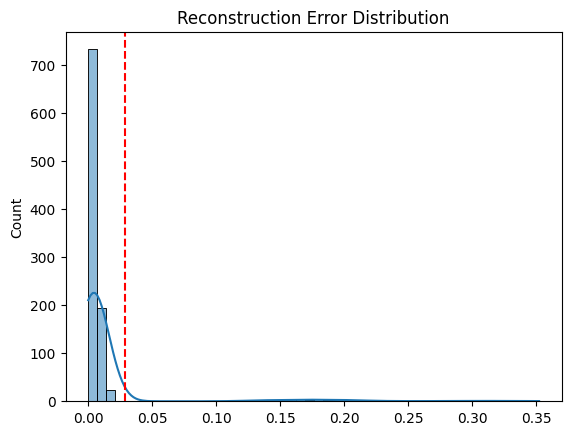

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers

# Step 1: Load dataset
df = pd.read_csv('/content/drive/MyDrive/Transaction_Data.csv')
print(df.head())

# Step 2: Preprocess
X = df.drop(columns=['Transaction_ID', 'Is_Anomaly'])
y = df['Is_Anomaly']
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Train-test split (only normal data for training)
X_train = X_scaled[y == 0]
X_test = X_scaled
y_test = y.values

# Step 4: Build Autoencoder model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu', activity_regularizer=regularizers.l1(1e-4))(input_layer)
encoded = Dense(4, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Step 5: Train Autoencoder
history = autoencoder.fit(X_train, X_train,
                          epochs=100,
                          batch_size=32,
                          validation_split=0.2,
                          verbose=0)

# Step 6: Reconstruction error
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Step 7: Set anomaly threshold
threshold = np.percentile(mse, 95)
print("Reconstruction Error Threshold:", threshold)

# Step 8: Predict anomalies
predictions = (mse > threshold).astype(int)

# Step 9: Evaluation
print(classification_report(y_test, predictions))
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='r', linestyle='--')
plt.title("Reconstruction Error Distribution")
plt.show()
